In [21]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
#plt.rcParams.update(plt.rcParamsDefault)
import scienceplots


import torch
import scipy.io
import time
import torch.nn as nn
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import FixDOEElement
from utils.units import *

# Fig1. Post-quantization

<Figure size 4800x3000 with 0 Axes>

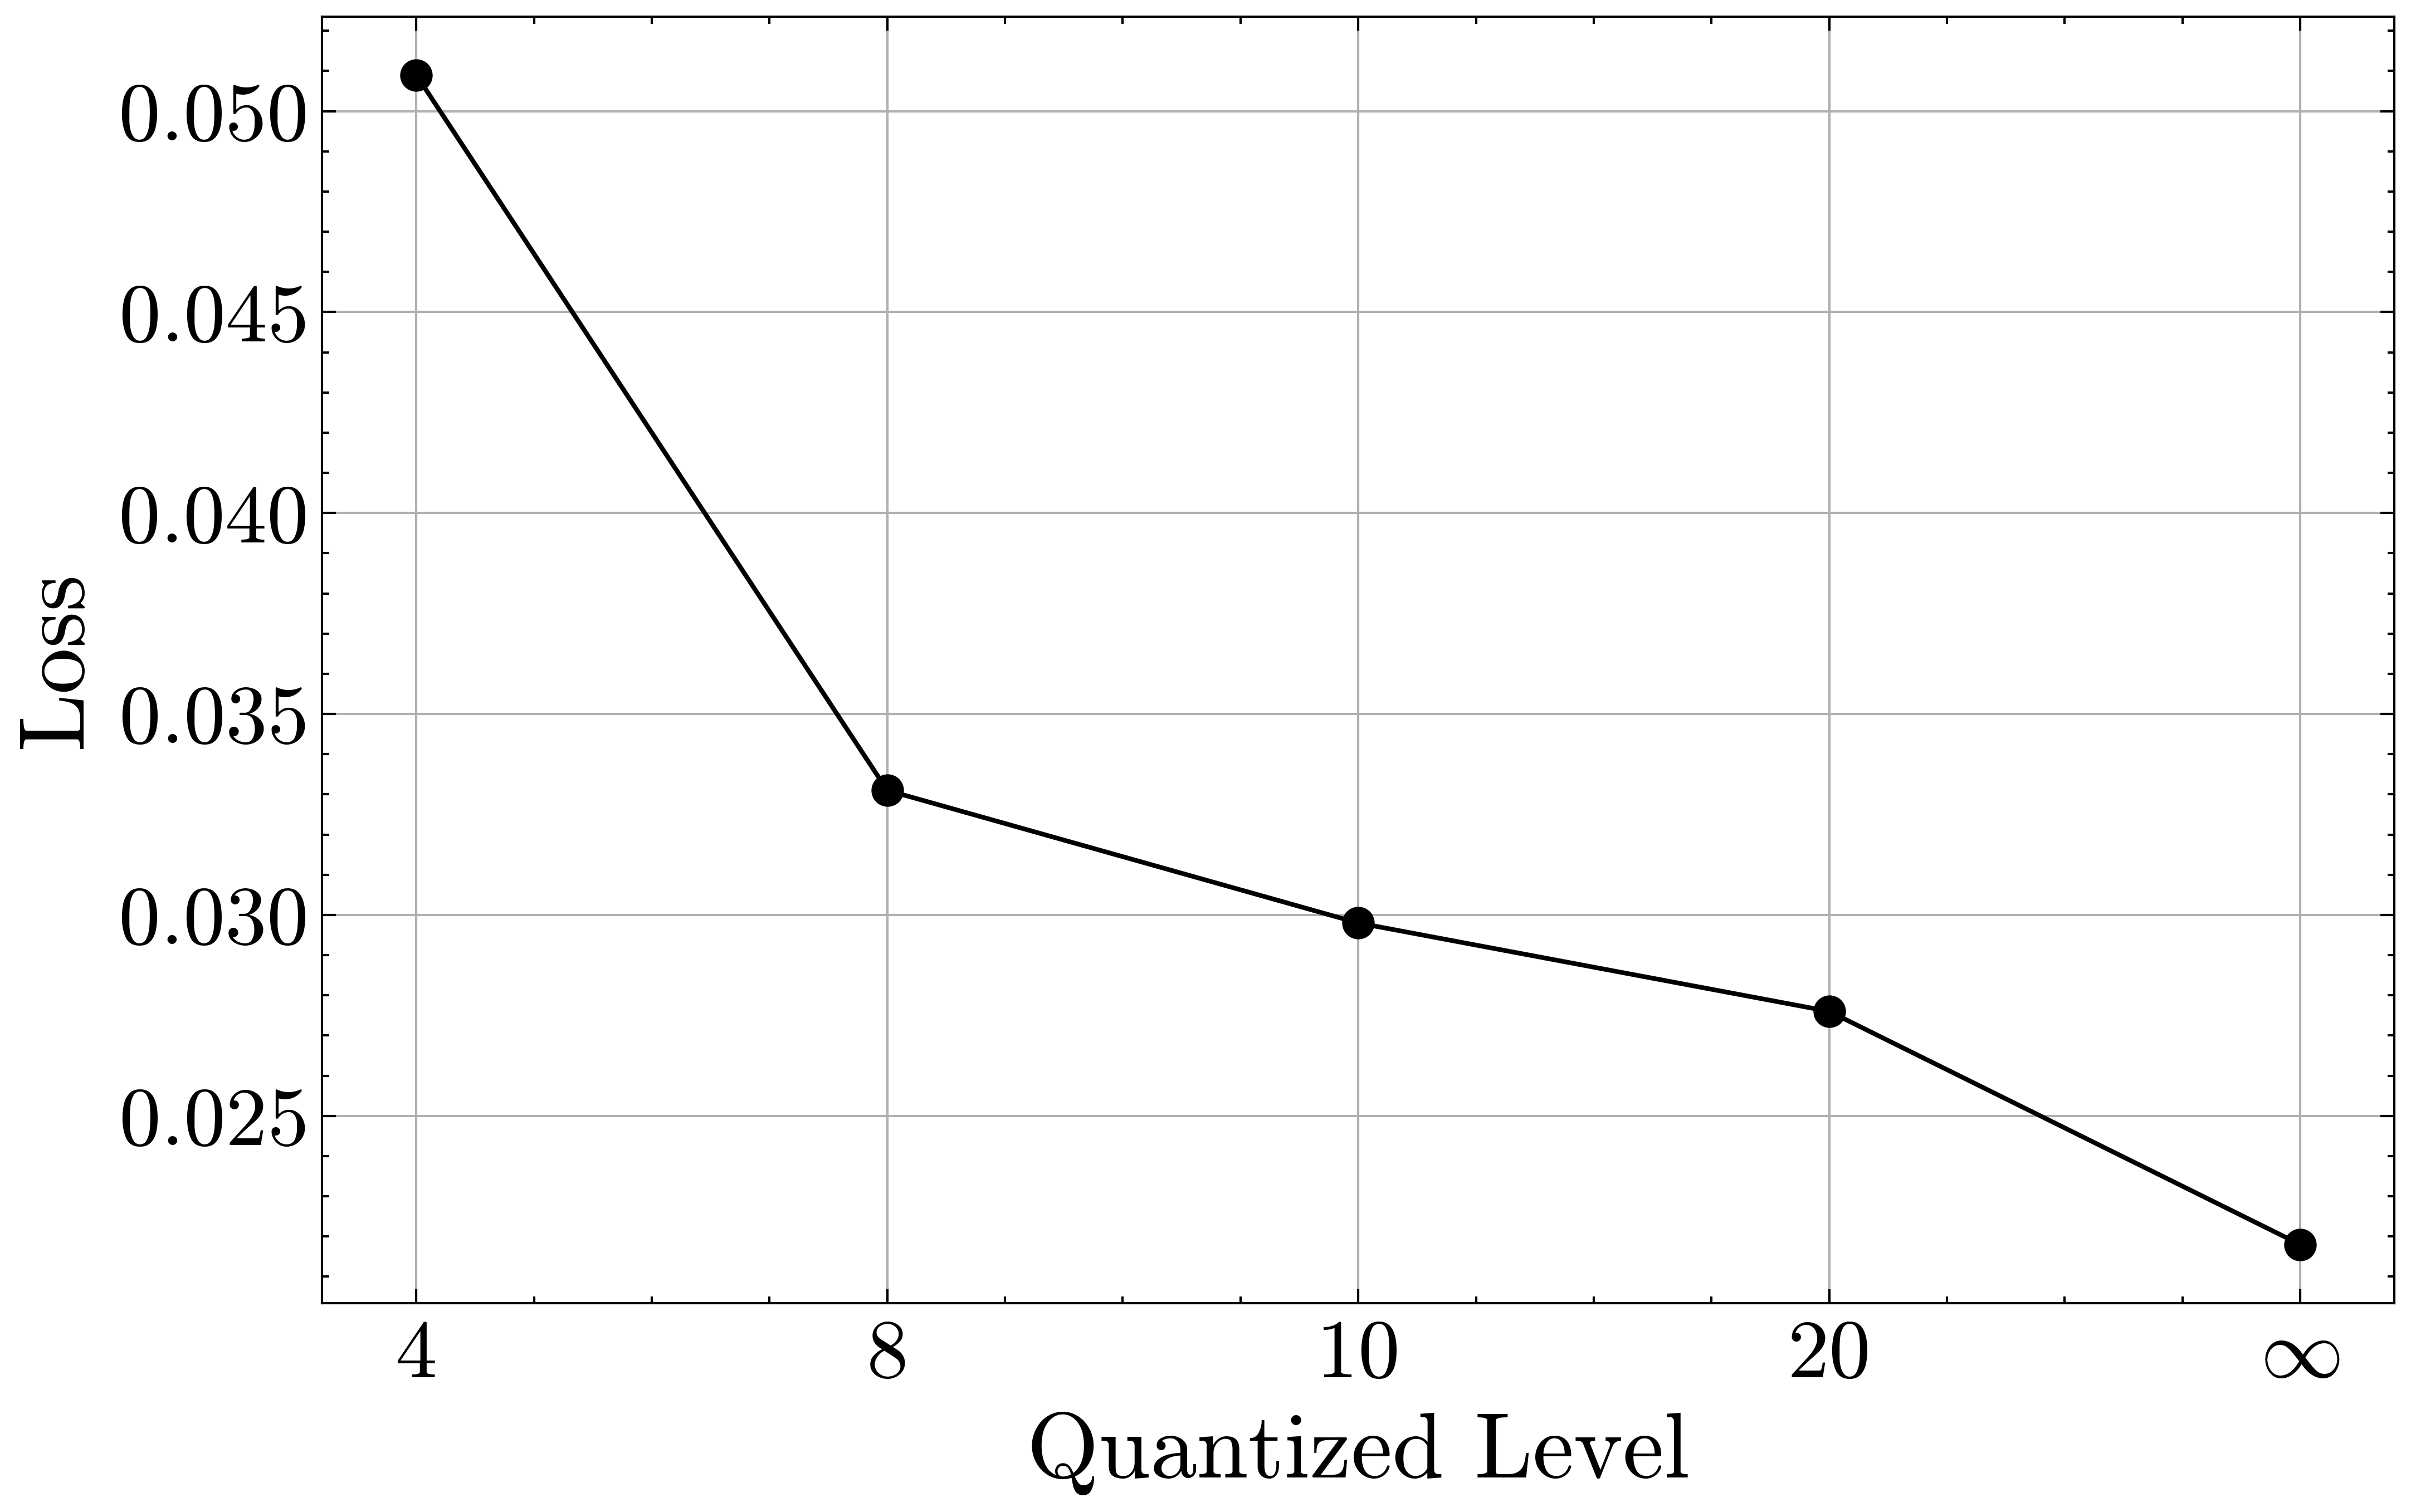

In [22]:
plt.style.use(['science','ieee', 'no-latex'])
plt.figure(figsize=(8, 5))
quantized_level = [2, 4, 6, 8, 10]
loss_wo_noise = [0.0509, 0.0331, 0.0298, 0.0276, 0.0218]
    
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(quantized_level, loss_wo_noise, marker='o', linestyle='-')
# Labels
plt.xlabel('Quantized Level', fontsize=20)
plt.ylabel('Loss', fontsize=20)
#plt.title('Loss vs. Quantized Level')
plt.grid(True)
# Adjusting x-axis to handle infinity symbol
plt.xticks([2, 4, 6, 8, 10], ['4', '8', '10', '20', '$\infty$'])
plt.xticks(fontsize=18)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=18) 
# Save as PDF
plt.show()
#plt.savefig('loss_vs_quantized_level.jpg', format='jpg', dpi=600)
#plt.savefig('loss_vs_quantized_level.pdf', format='pdf', dpi=600)

# Plot 1d-profile

In [241]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

In [242]:
class Submm_Setup_test(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 height_map,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.height_map = height_map
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FixDOEElement(height_map=self.height_map, tolerance=0*um, material=[epsilon, tand])
        
        self.asm_prop4 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field)
        
        final_field2 = self.asm_prop4(field)
        
        return final_field2

In [243]:
data = np.load('./plot_data/example_1/splitter_full_precision.npy', allow_pickle=True)
height_map = data.item().get('thickness')

# Calculate padding sizes
pad_width = ((10, 10), (10, 10))  # ((top, bottom), (left, right))

# Apply zero-padding
height_map = np.pad(height_map, pad_width=pad_width, mode='constant', constant_values=0)

In [244]:
setup = Submm_Setup_test(input_dxy=input_dxy, 
                         input_field_shape=input_field_shape, 
                         height_map=height_map,
                         wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [245]:
out_field = setup.forward(iter_frac=None)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


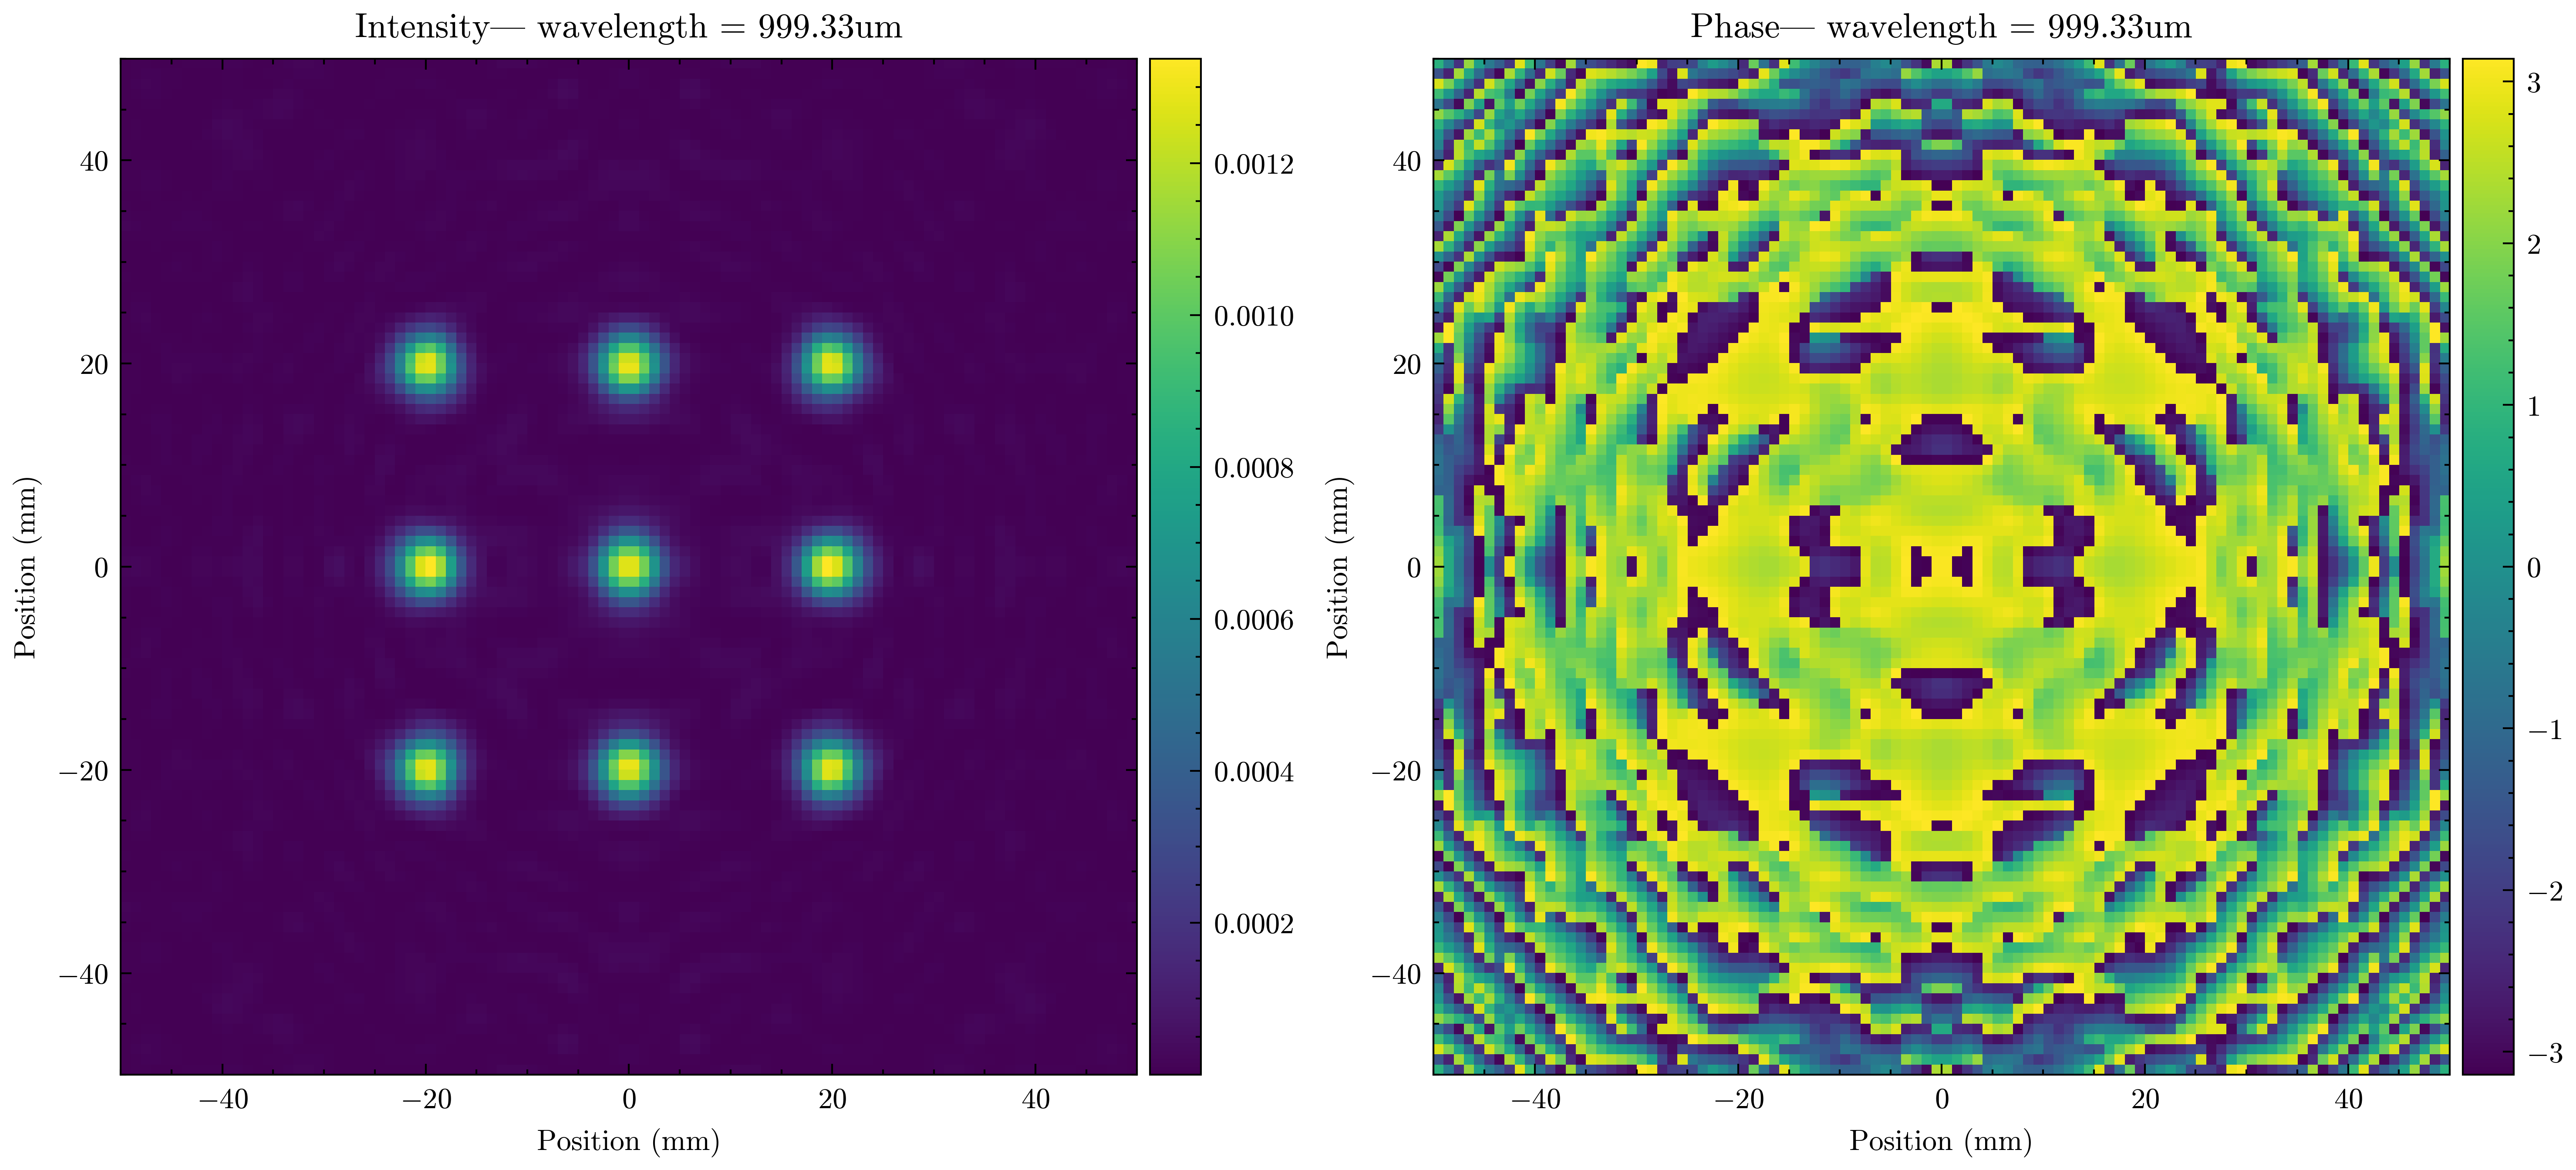

In [246]:
out_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [247]:
x_profile = out_field.data[0, 0, 50, :].abs().cpu()
x_profile = x_profile / torch.max(x_profile)

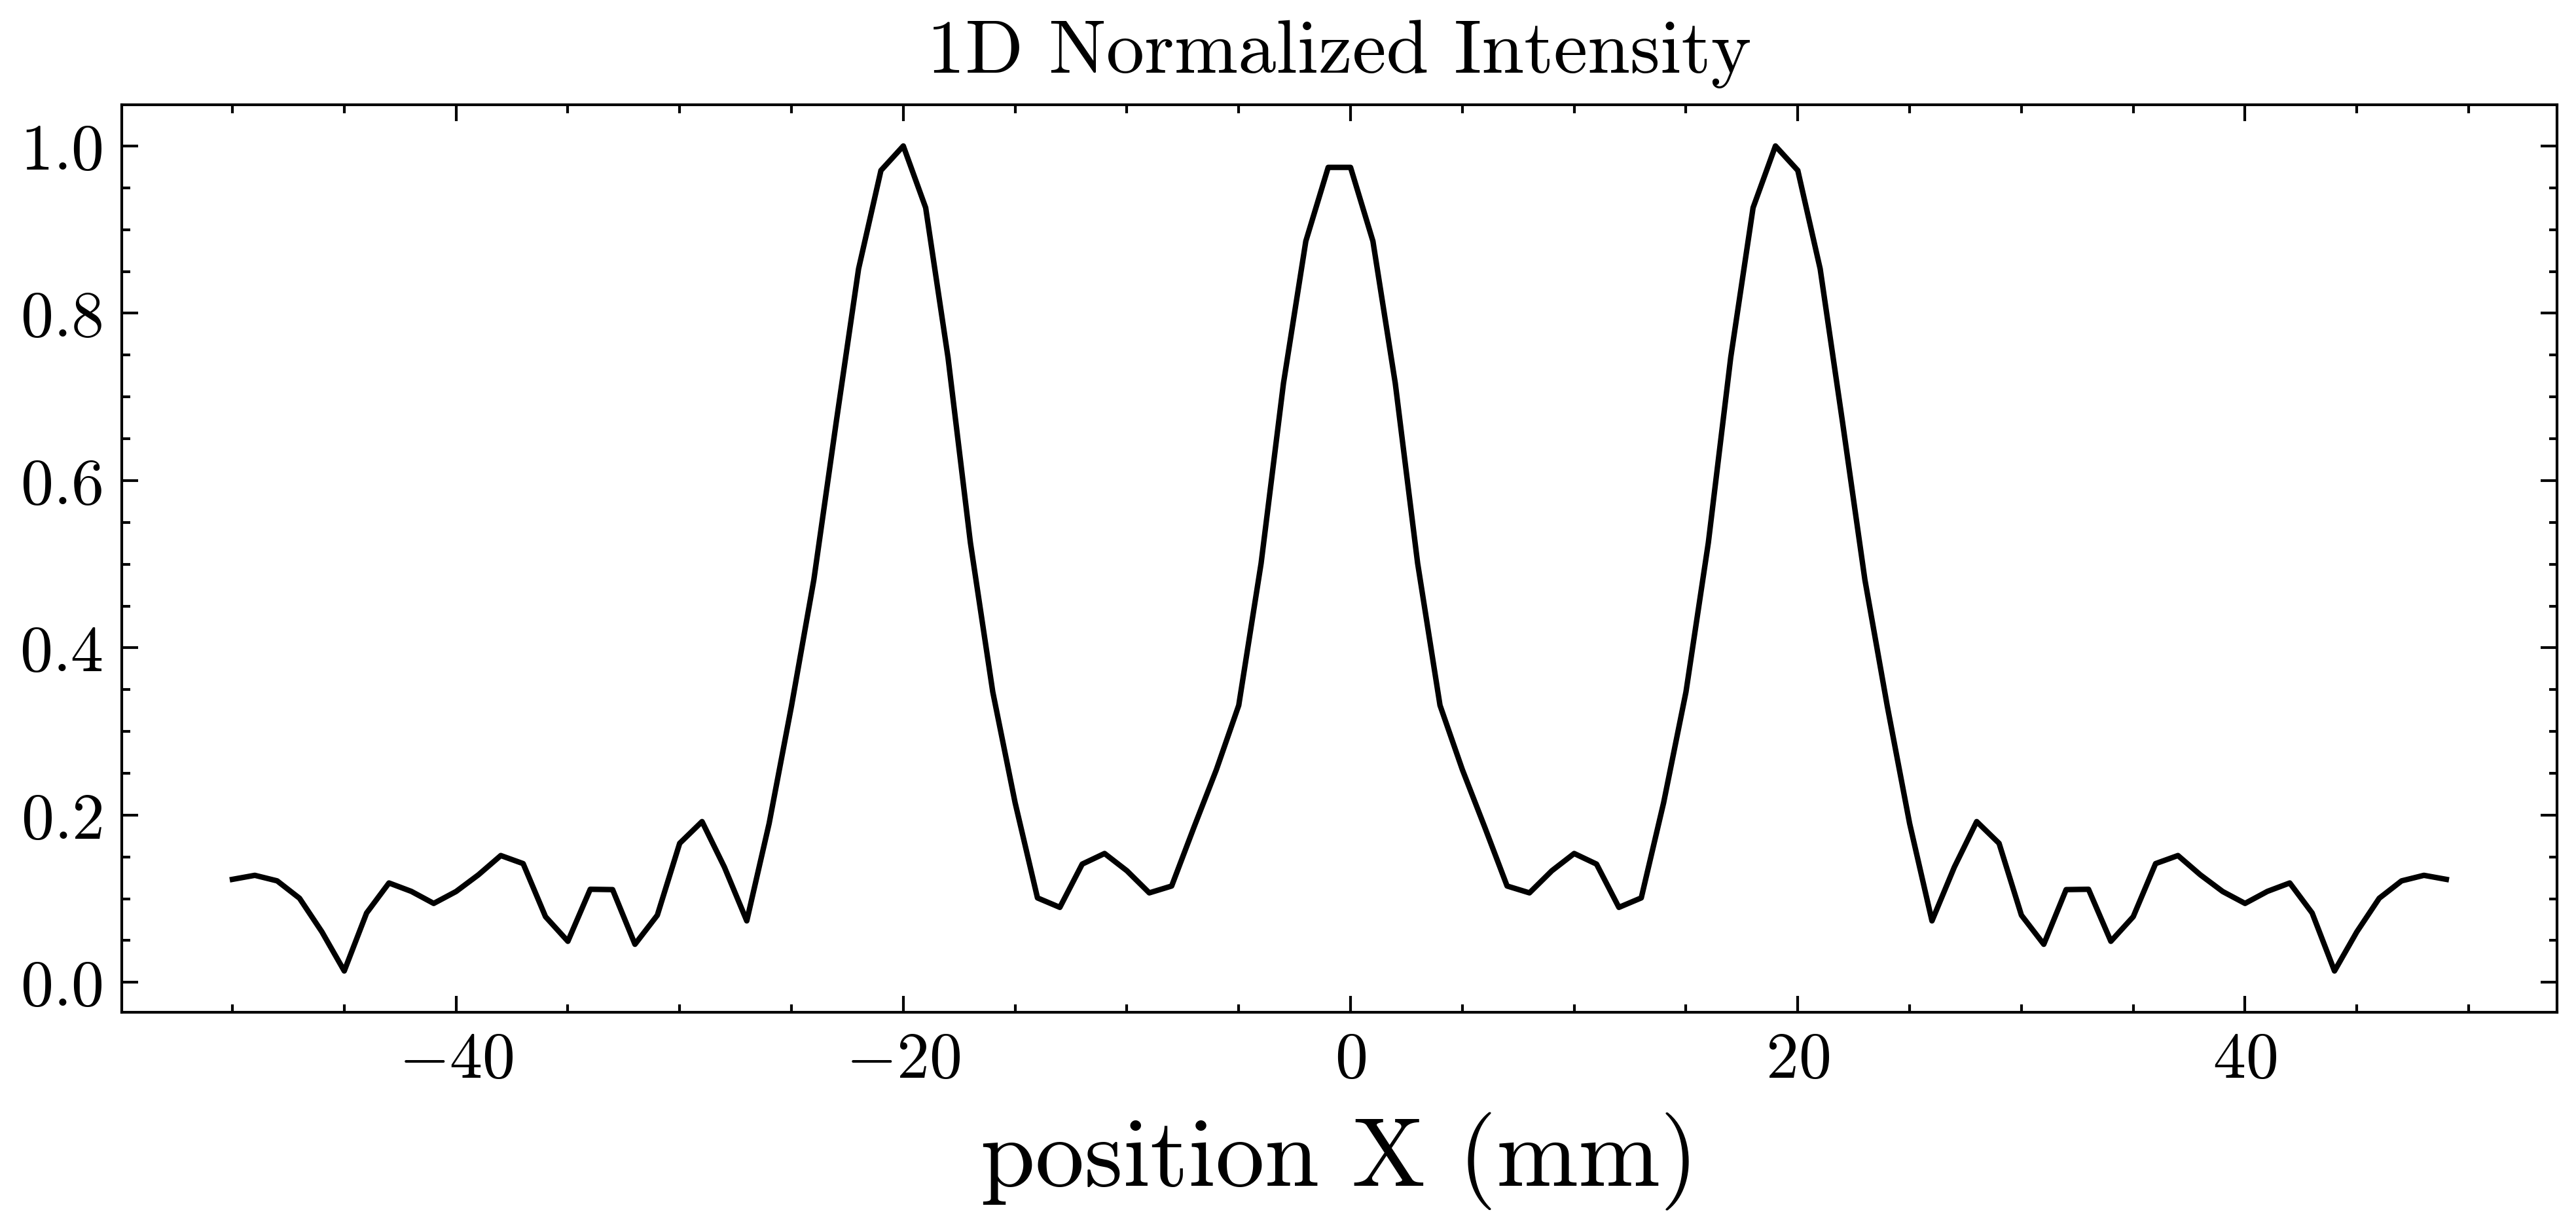

In [249]:
plt.figure(figsize=(8, 3))
plt.plot(np.arange(-50, 50), x_profile)
plt.xticks(fontsize=12)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=12) 
plt.title('1D Normalized Intensity', fontsize=14)
plt.xlabel('position X (mm)', fontsize=18)

plt.savefig('1.svg', format='svg', dpi=600)

In [174]:
loss_full = np.load('./plot_data/example_1/loss_curve_full.npy')
loss_GS = np.load('./plot_data/example_1/loss_curve_GS.npy')
loss_PSQ = np.load('./plot_data/example_1/loss_curve_PSQ.npy')
loss_STE = np.load('./plot_data/example_1/loss_curve_STE.npy')
loss_ours = np.load('./plot_data/example_1/loss_curve_Ours.npy')

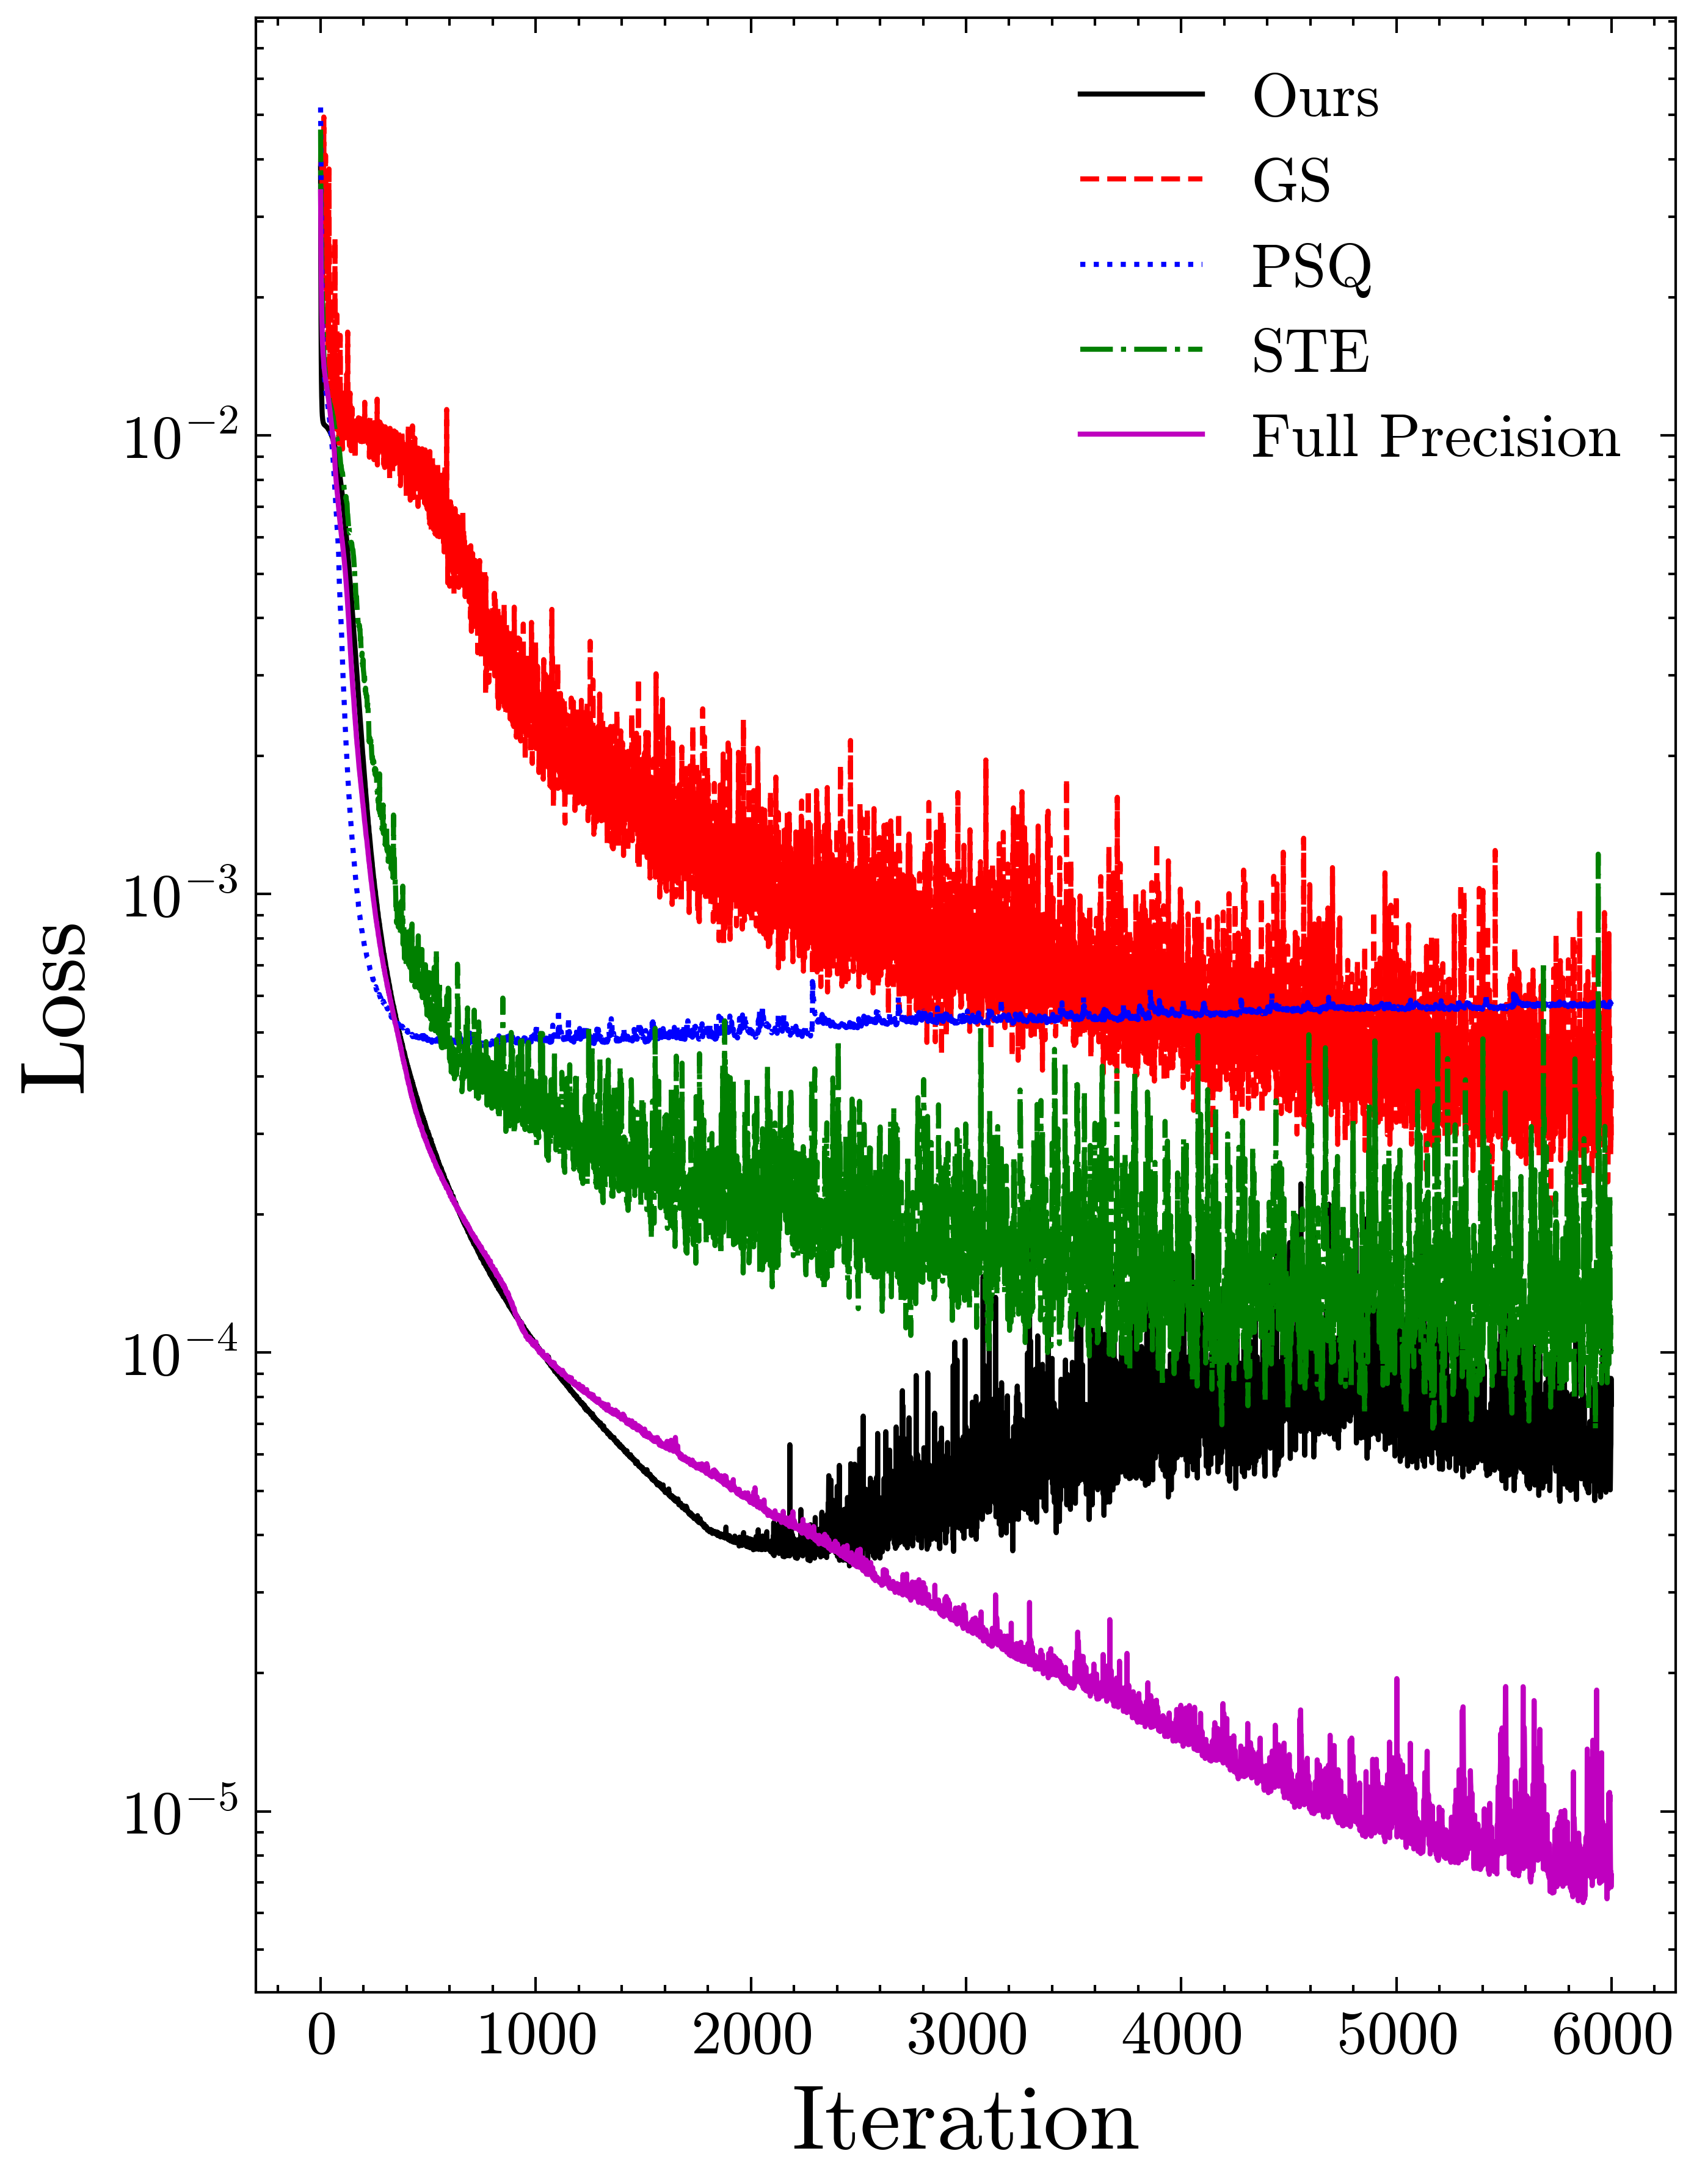

In [175]:
plt.figure(figsize=(5, 7))
# Plotting each loss with a label
plt.plot(loss_ours, label='Ours')
plt.plot(loss_GS, label='GS')
plt.plot(loss_PSQ, label='PSQ')
plt.plot(loss_STE, label='STE')
plt.plot(loss_full, label='Full Precision', color='m')
plt.yscale('log')
plt.xticks(fontsize=12)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=12) 
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)

# Adding a legend
plt.legend(fontsize=12)

In [196]:
loss_full = np.load('./plot_data/example_2/loss_curve_full.npy')
loss_GS = np.load('./plot_data/example_2/loss_curve_GQ.npy')
loss_PSQ = np.load('./plot_data/example_2/loss_curve_PSQ.npy')
loss_STE = np.load('./plot_data/example_2/loss_curve_STE.npy')
loss_ours = np.load('./plot_data/example_2/loss_curve_Ours.npy')

np.min(loss_ours)

0.026543570682406425

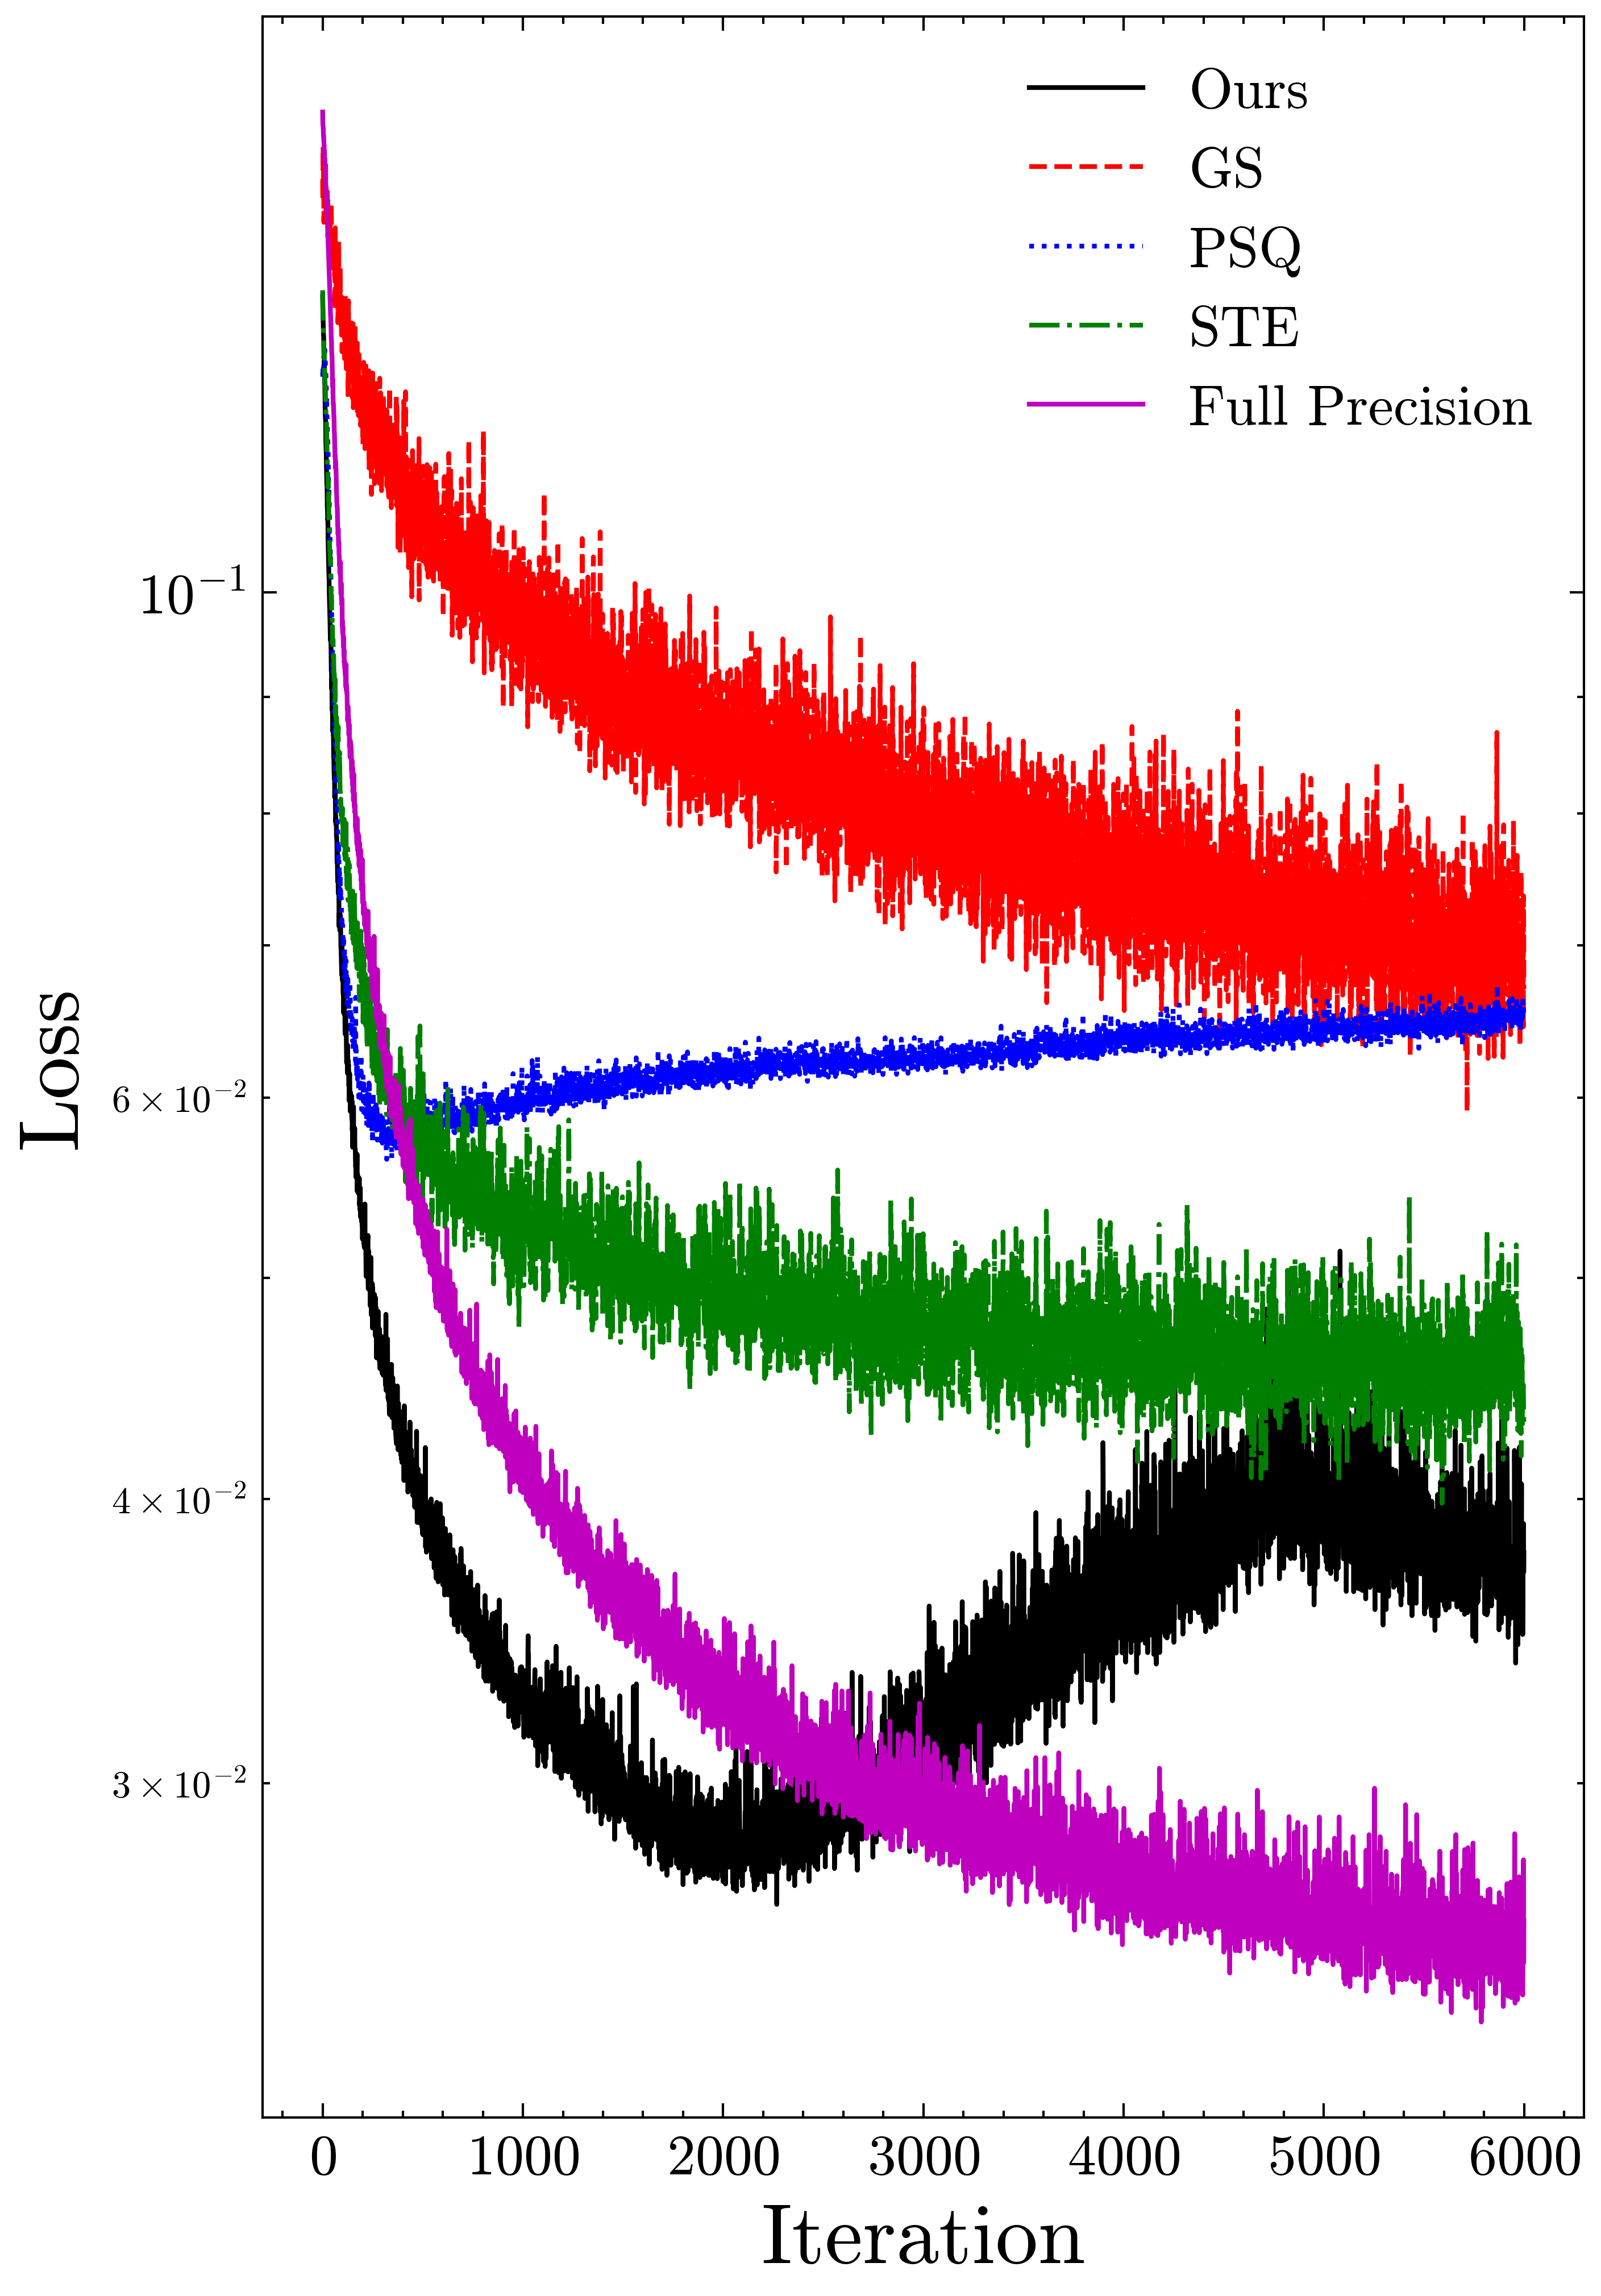

In [172]:
plt.figure(figsize=(5, 8))
# Plotting each loss with a label
plt.plot(loss_ours, label='Ours')
plt.plot(loss_GS, label='GS')
plt.plot(loss_PSQ, label='PSQ')
plt.plot(loss_STE, label='STE')
plt.plot(loss_full, label='Full Precision', color='m')

plt.yscale('log')
plt.xticks(fontsize=12)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=12) 
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)

# Adding a legend
plt.legend(fontsize=12)

In [240]:
loss_full = np.load('./plot_data/example_3/loss_curve_full.npy')
loss_GS = np.load('./plot_data/example_3/loss_curve_GQ.npy')
loss_PSQ = np.load('./plot_data/example_3/loss_curve_PSQ.npy')
loss_STE = np.load('./plot_data/example_3/loss_curve_STE.npy')
loss_ours = np.load('./plot_data/example_3/loss_curve_Ours.npy')

np.min(loss_ours) / 0.0001

2.3525257711298764

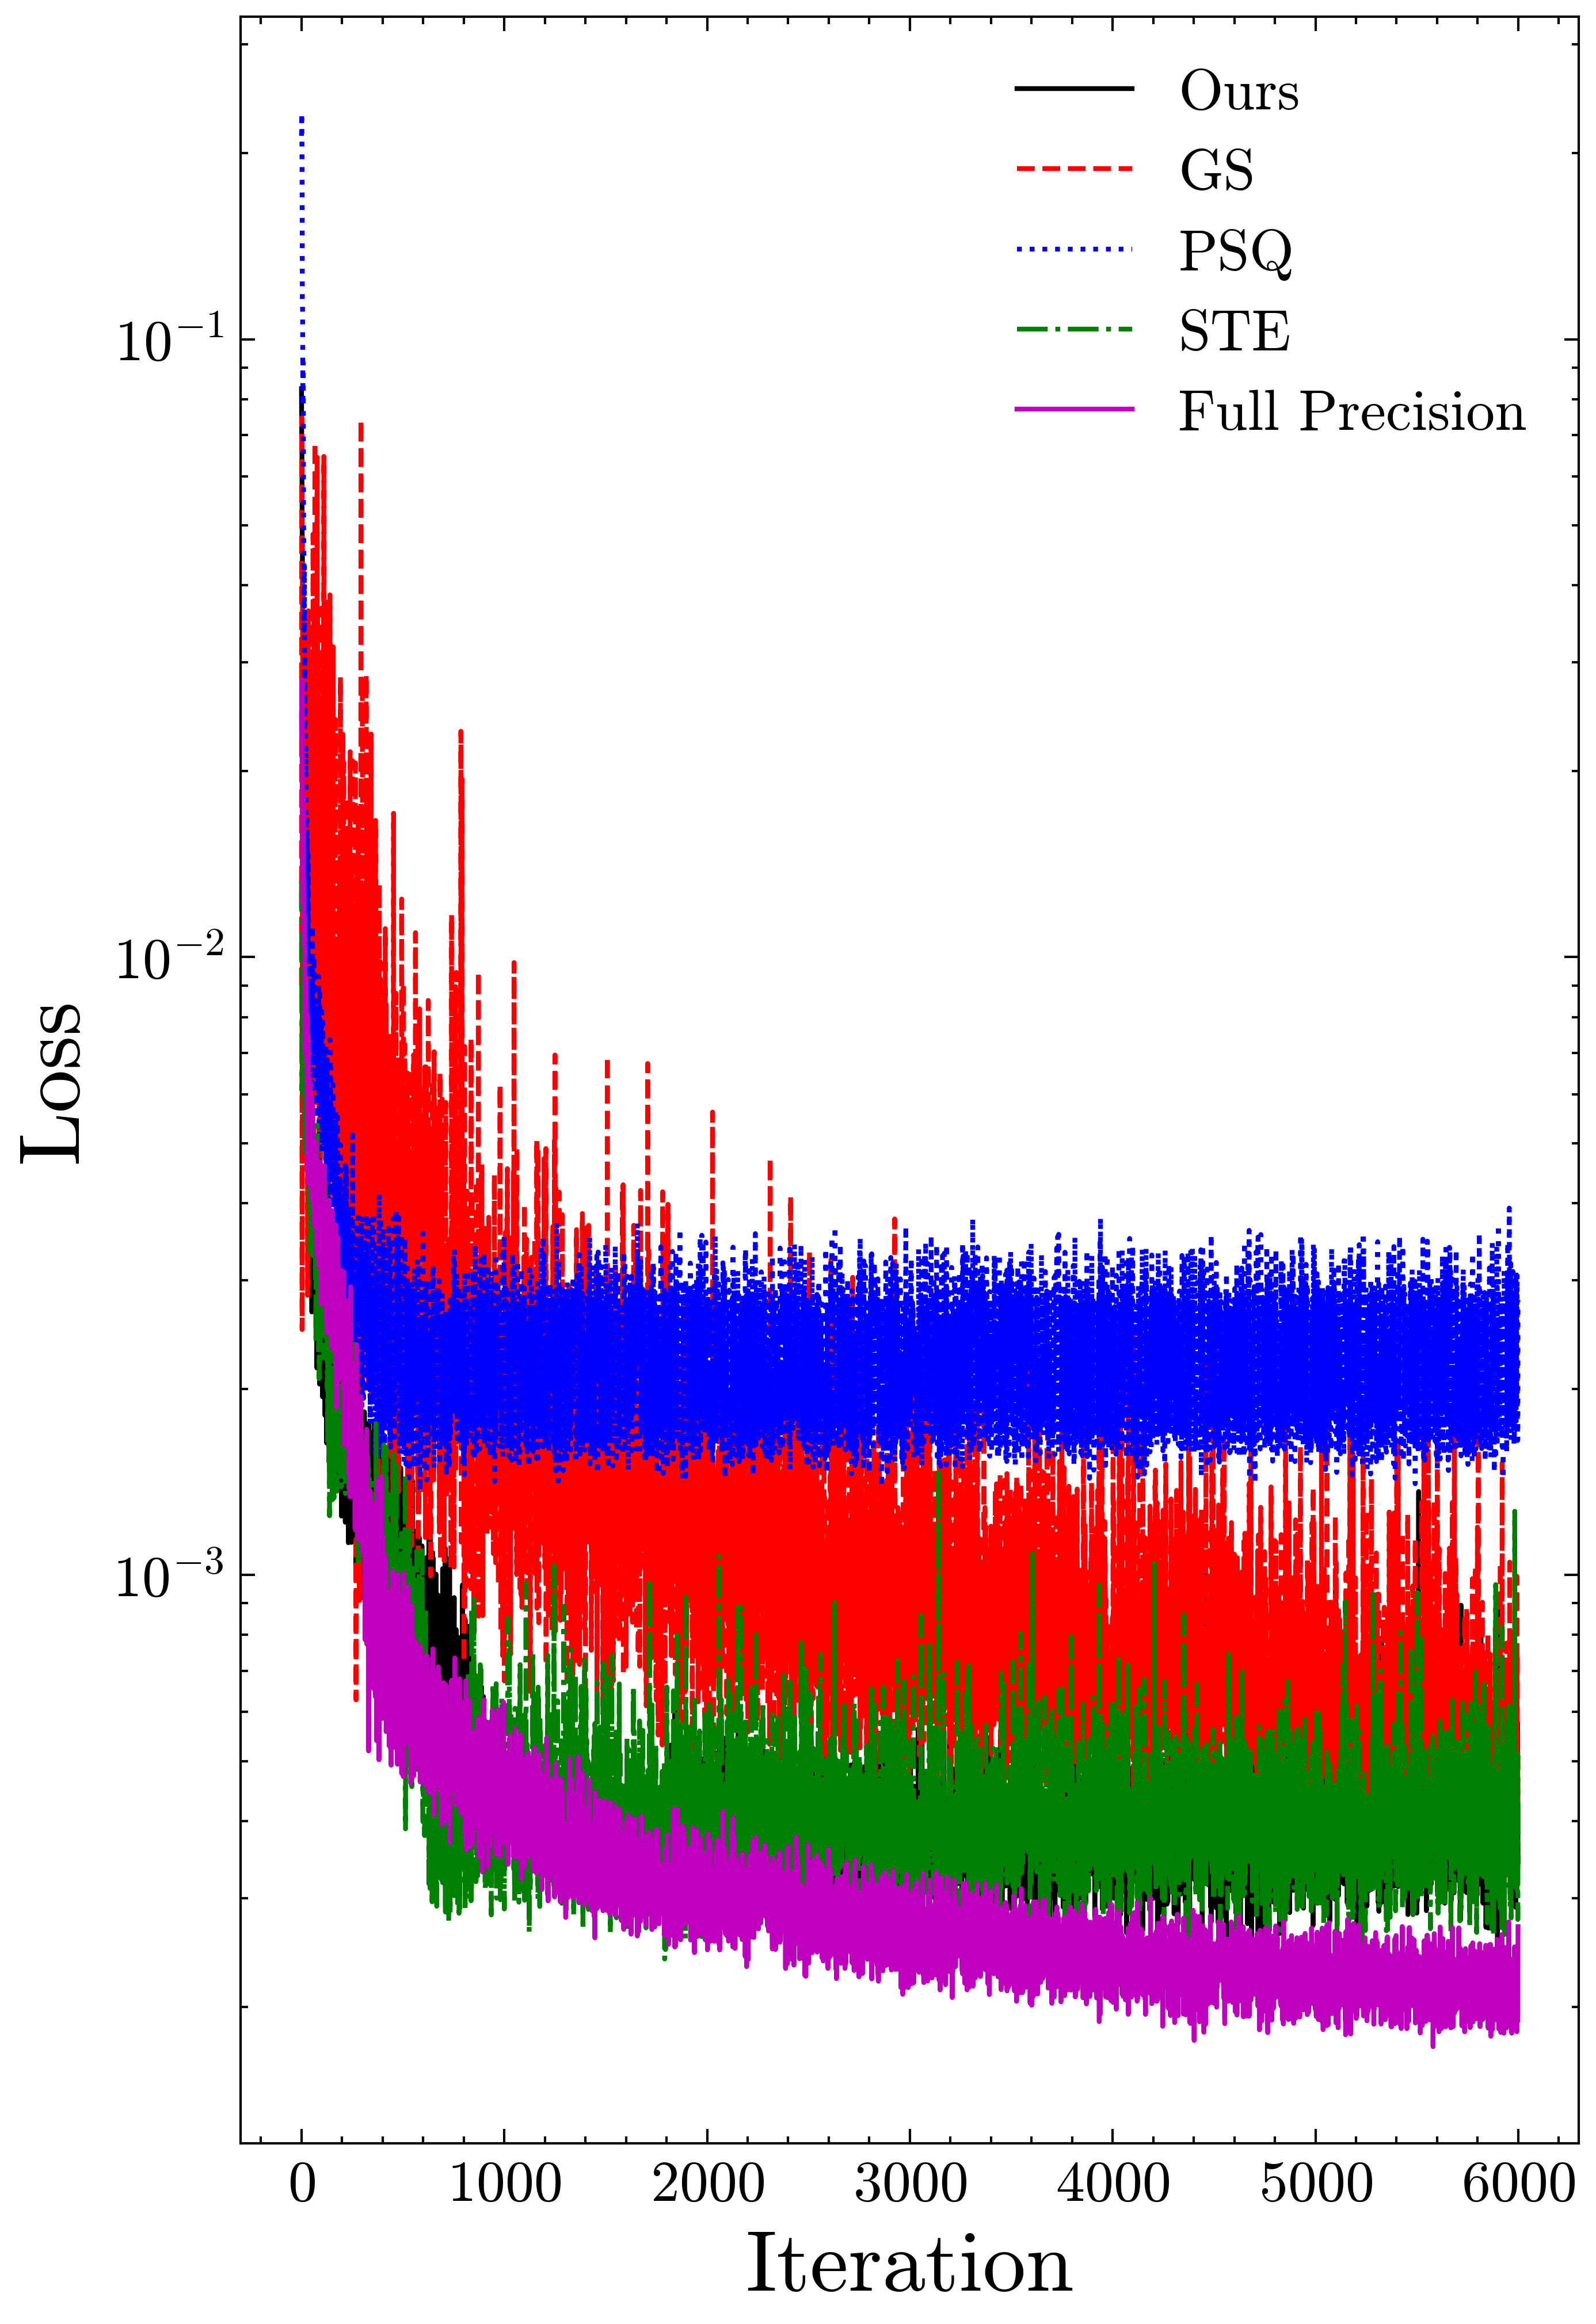

In [198]:
plt.figure(figsize=(5, 8))
# Plotting each loss with a label
plt.plot(loss_ours, label='Ours')
plt.plot(loss_GS, label='GS')
plt.plot(loss_PSQ, label='PSQ')
plt.plot(loss_STE, label='STE')
plt.plot(loss_full, label='Full Precision', color='m')

plt.yscale('log')
plt.xticks(fontsize=12)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=12) 
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Loss', fontsize=18)

# Adding a legend
plt.legend(fontsize=12)

In [221]:
cutoff_full = np.load('./plot_data/example_3/extend_dof_full_cutoff.npy')
cutoff_GS = np.load('./plot_data/example_3/extend_dof_GQ_cutoff.npy')
cutoff_PSQ = np.load('./plot_data/example_3/extend_dof_PSQ_cutoff.npy')
cutoff_STE = np.load('./plot_data/example_3/extend_dof_STE_cutoff.npy')
cutoff_ours = np.load('./plot_data/example_3/extend_dof_Ours_cutoff.npy')

# normalized
cutoff_full = cutoff_full / np.max(cutoff_full)
cutoff_GS = cutoff_GS / np.max(cutoff_GS)
cutoff_PSQ = cutoff_PSQ / np.max(cutoff_PSQ)
cutoff_STE = cutoff_STE / np.max(cutoff_STE)
cutoff_ours = cutoff_full / np.max(cutoff_ours)

Text(0, 0.5, 'Position Y (mm)')

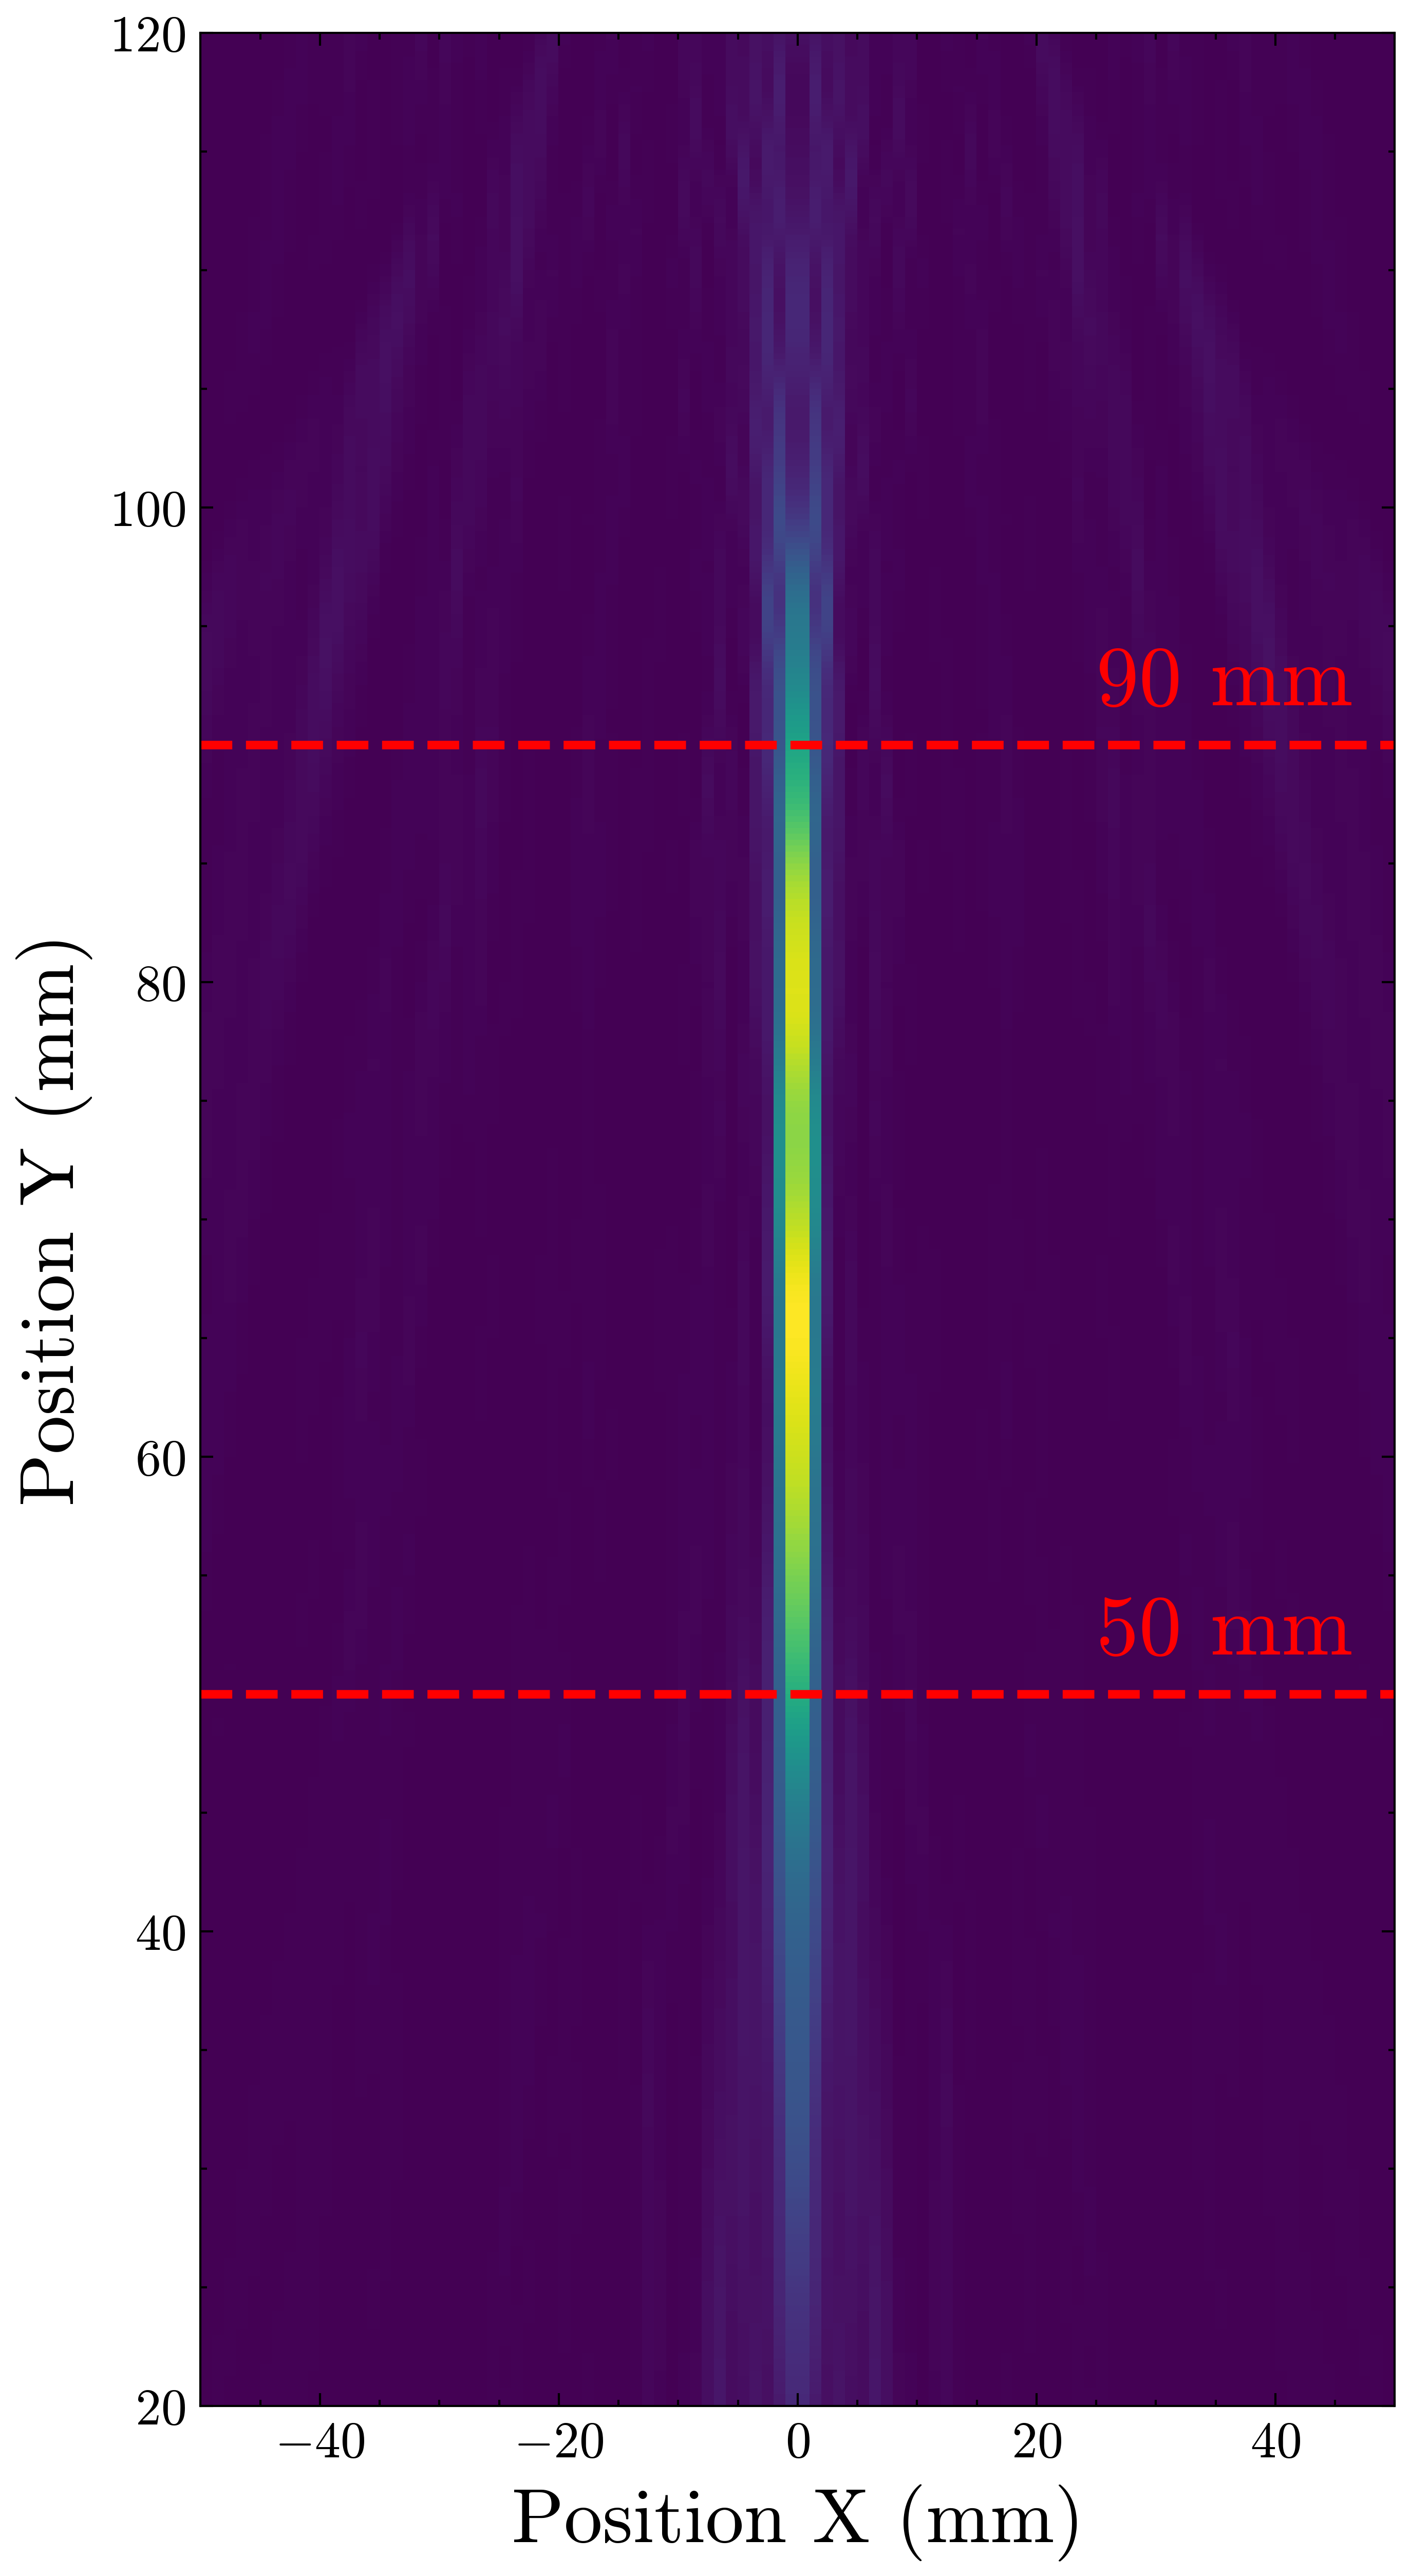

In [233]:
plt.figure(figsize=(5, 10))

extent = [-50, 50, 20, 120]
plt.imshow(cutoff_full, extent=extent, aspect='auto')

# Plot red dashed lines at y=50 and y=90
plt.axhline(y=50, color='red', linestyle='--', linewidth=2)
plt.axhline(y=90, color='red', linestyle='--', linewidth=2)

# Add annotations for 50 mm and 90 mm
plt.text(25, 51, '50 mm', color='red', fontsize=20, verticalalignment='bottom')
plt.text(25, 91, '90 mm', color='red', fontsize=20, verticalalignment='bottom')


plt.xticks(fontsize=12)  # Change the fontsize for the x-axis ticks
plt.yticks(fontsize=12) 
plt.xlabel('Position X (mm)', fontsize=18)
plt.ylabel('Position Y (mm)', fontsize=18)